# Подключение основных библиотек и загрузка данных 

### Для Google Colaboratory

In [ ]:
# Библиотека wfdb отсутствует в Google Collab
!pip install wfdb

In [ ]:
# Подключение Google Drive к виртуальной машине.
from google.colab import drive
drive.mount('/content/drive')

In [3]:
# Копирование данных с Google Drive на локальный диск виртуальной машины.
!cp -r /content/drive/MyDrive/MachineLearningCollab/X_testCopy.npy .
!cp -r /content/drive/MyDrive/MachineLearningCollab/X_trainCopy.npy .
!cp -r /content/drive/MyDrive/MachineLearningCollab/y_testCopy.npy .
!cp -r /content/drive/MyDrive/MachineLearningCollab/y_trainCopy.npy .

### Подключение библиотек

In [ ]:
# Подключение библиотек.
import pandas as pd
import numpy as np
import wfdb
import ast

#import sklearn
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import matplotlib.pyplot as plt
#import matplotlib.cm     as cm
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

print("tf.__version__:", tf.__version__)
print("keras.__version__", keras.__version__)

from keras import layers
from keras import models

### Первая загрузка данных

In [2]:
np.random.seed(42)

def load_raw_data(df, sampling_rate, path):
  if sampling_rate == 100:
    data = [wfdb.rdsamp(path+f) for f in df.filename_lr] # low rate
  else:
    data = [wfdb.rdsamp(path+f) for f in df.filename_hr] # high rate
  data = np.array([signal for signal, meta in data])
  return data

path = 'part/to/ptbxl/'
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col = 'ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col = 0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
  tmp = []
  for key in y_dic.keys():
    if key in agg_df.index:
      tmp.append(agg_df.loc[key].diagnostic_class)
  return list(set(tmp))

# apply diagnistic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

del X, Y

### Некоторые функции

In [ ]:
# Функция, которая разделит списки с 2 и более элементами.
def splitData(X, y):
  indexDel = [] # хранит индексы список, которые хранят более 1 элемента (удаляются)
  yTmp = np.zeros((0, 1)) # хранит элементы (списки с 1 элементом), которые добавляются в конец y
  XTmp = np.zeros((0, 1000, 12)) # хранит элементы (списки с 1 элементом), которые добавляются в конце X
  for i in range(y.size):
    if len(y[i]) > 1:
      indexDel.append(i)
      for j in range(len(y[i])):
        yTmp = np.concatenate((yTmp, np.array([y[i][j:j+1]])))
        XTmp = np.concatenate((XTmp, np.array([X[i]])))
  y = np.delete(y, indexDel, axis = 0)
  X = np.delete(X, indexDel, axis = 0)
  y = y.reshape(y.size, 1)
  for i in range(y.size):
    y[i] = (y[i].tolist()[0])
  y = np.concatenate((y, yTmp))
  X = np.concatenate((X, XTmp))
  return X, y

# Поиск пустых значений в массиве меток.
def emptyLabel(y):
  # Найдем ecg_id строк, где не определен класс.
  ecg_idEmpty = [] # массив индексов пустых значений по ecg_id [1, ...]
  ecg_idEmptyIndex = [] # массив индекс пустых значений по [0, ...]
  sum_empty = 0 # подсчет пустых значений
  for i in range(y.size):
    if len(y.values[i]) == 0:
      ecg_idEmpty.append(y.index[i])
      ecg_idEmptyIndex.append(i) 
      sum_empty += 1
  # print(sum_empty)
  # print(ecg_idEmpty)
  # print(ecg_idEmptyIndex)
  return sum_empty, ecg_idEmpty, ecg_idEmptyIndex


# Анализ данных

### Первичный анализ

In [ ]:
# Вывести конкретное (все, если указана бесконечность в качестве параметра threshold) число элементов массива ndarray.
# np.set_printoptions(threshold=10) # np.inf

In [ ]:
# Тип данных переменных y_train и y_test, содержащие метки (диагноз).
print(type(y_train))
print(type(y_test))
# Размерность.
print(y_train.ndim)
print(y_test.ndim)
# Форма переменных и их размер (количество меток).
print(y_train.shape, y_train.size)
print(y_test.shape, y_test.size)
# Общее количество элементов (меток).
print("size:", y_train.size + y_test.size)

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>
1
1
(19634,) 19634
(2203,) 2203
size: 21837


In [ ]:
# Тип данных переменных X_train и X_test, содержащие все объекты (экземпляры, образцы) с их атрибутами (числовое значение сигналов по 12 отведениям, полученных в течение 10 секунд).
print(type(X_test))
print(type(X_train))
# Размерность.
print(X_train.ndim)
print(X_test.ndim)
# Форма переменных и их размер (количество образцов).
print(X_train.shape, X_train.size)
print(X_test.shape, X_test.size)
# Общее количество элементов (образцов).
print("size:", X_train.size + X_test.size)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
3
3
(19634, 1000, 12) 235608000
(2203, 1000, 12) 26436000
size: 262044000


In [ ]:
# Посмотрим на исходный вид меток.
print(y_train)

ecg_id
1        [NORM]
2        [NORM]
3        [NORM]
4        [NORM]
5        [NORM]
          ...  
21833    [STTC]
21834    [NORM]
21835    [STTC]
21836    [NORM]
21837    [NORM]
Name: diagnostic_superclass, Length: 19634, dtype: object


In [ ]:
# Посмотрим на исходный вид показателей.
print(X_train)

[[[-1.190e-01 -5.500e-02  6.400e-02 ... -2.600e-02 -3.900e-02 -7.900e-02]
  [-1.160e-01 -5.100e-02  6.500e-02 ... -3.100e-02 -3.400e-02 -7.400e-02]
  [-1.200e-01 -4.400e-02  7.600e-02 ... -2.800e-02 -2.900e-02 -6.900e-02]
  ...
  [ 6.900e-02  0.000e+00 -6.900e-02 ...  2.400e-02 -4.100e-02 -5.800e-02]
  [ 8.600e-02  4.000e-03 -8.100e-02 ...  2.420e-01 -4.600e-02 -9.800e-02]
  [ 2.200e-02 -3.100e-02 -5.400e-02 ...  1.430e-01 -3.500e-02 -1.200e-01]]

 [[ 4.000e-03  1.380e-01  1.340e-01 ...  1.920e-01  8.300e-02  8.800e-02]
  [-2.000e-02  1.160e-01  1.360e-01 ...  1.560e-01  5.700e-02  6.300e-02]
  [-5.300e-02  9.200e-02  1.450e-01 ...  1.070e-01  1.300e-02  2.200e-02]
  ...
  [ 1.210e-01  3.980e-01  2.770e-01 ... -1.065e+00 -4.920e-01 -1.560e-01]
  [-3.260e-01  5.700e-02  3.830e-01 ... -2.800e-01 -1.750e-01 -7.100e-02]
  [-3.480e-01 -5.600e-02  2.920e-01 ... -3.080e-01 -2.310e-01 -1.450e-01]]

 [[-2.900e-02 -7.900e-02 -4.900e-02 ... -1.030e-01 -7.600e-02 -6.600e-02]
  [-3.500e-02 -7.000e-

In [ ]:
# Содержимое по индексам и значения (тип данных Series, DataFrame пакета Pandas)
print(y_train.index, '\n')
print(y_train.values, '\n')
print(y_train.index[0])
print(y_train.values[0])

Int64Index([    1,     2,     3,     4,     5,     6,     7,     8,    10,
               11,
            ...
            21828, 21829, 21830, 21831, 21832, 21833, 21834, 21835, 21836,
            21837],
           dtype='int64', name='ecg_id', length=19634) 

[list(['NORM']) list(['NORM']) list(['NORM']) ... list(['STTC'])
 list(['NORM']) list(['NORM'])] 

1
['NORM']


In [ ]:
# Посмотрим на содержание y_train (все данные).
for i in range(y_train.size): # можно вычесть некоторое значение, не большее y_train.size, чтобы ограничить число вывода
  print(y_train.values[i])

# Или так.

# for Class in y_train:
#   #print(Class)

### Пропущенные данные
Когда мы выделим уникальные значения в y_train и проведем подсчет каждого, то заметим, что существует пустые значения, которые повторяются 367 раз в тренировочном наборе.

In [ ]:
# Создать Ndarray Numpy копию Series Pandas.
y_trainNp = y_train.to_numpy()
print(type(y_trainNp))
print(y_trainNp.size)

<class 'numpy.ndarray'>
19634


In [ ]:
# Выделим уникальные значения y_train_np и посчитаем их количество.
unique, counts = np.unique(y_trainNp, return_counts = True)
print(unique, '\n', "unique.size: ", unique.size)
print(counts)

[list([]) list(['CD']) list(['CD', 'HYP']) list(['CD', 'MI'])
 list(['CD', 'MI', 'HYP']) list(['CD', 'MI', 'STTC'])
 list(['CD', 'MI', 'STTC', 'HYP']) list(['CD', 'STTC'])
 list(['CD', 'STTC', 'HYP']) list(['HYP'])
 list(['HYP', 'CD', 'MI', 'STTC']) list(['HYP', 'CD', 'STTC'])
 list(['HYP', 'MI', 'STTC']) list(['HYP', 'STTC']) list(['MI'])
 list(['MI', 'HYP']) list(['MI', 'STTC']) list(['MI', 'STTC', 'HYP'])
 list(['NORM']) list(['NORM', 'CD']) list(['NORM', 'CD', 'MI', 'HYP'])
 list(['NORM', 'CD', 'STTC']) list(['NORM', 'HYP']) list(['NORM', 'STTC'])
 list(['STTC']) list(['STTC', 'CD', 'MI', 'HYP']) list(['STTC', 'HYP'])
 list(['STTC', 'MI', 'HYP'])] 
 unique.size:  28
[ 367 1525  273 1167  112  202    1  434  135  480   14   51   19  149
 2282  166  541    1 8170  362    1    5    2   24 2163  127  561  300]


<AxesSubplot:>

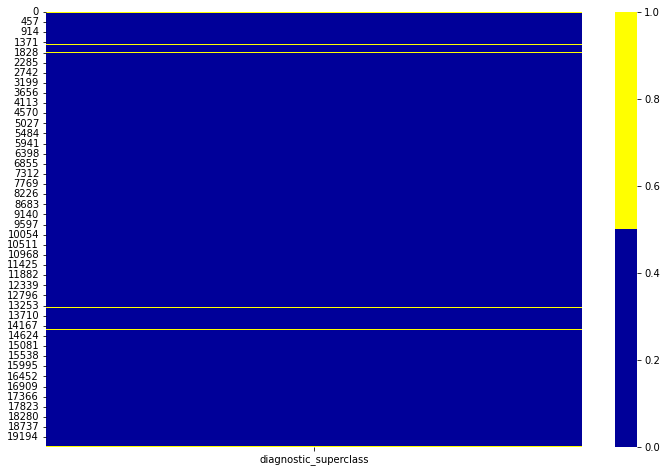

In [ ]:
# Визуализация с применением seaborn.

# Создаем копию.
y_trainTmp = y_train

# Конвертируем list в str.
for i in range(y_trainTmp.size):
  y_trainTmp.iloc[i] = ''.join(y_trainTmp.iloc[i])
y_train_rI = y_trainTmp.reset_index()
y_train_rI_cat = y_train_rI[['diagnostic_superclass']]

colours = ['#000099', '#ffff00']
fig, ax = plt.subplots(figsize = (12, 8))
sns.heatmap(y_train_rI_cat[:].isin(['']), cmap = sns.color_palette(colours))

<AxesSubplot:>

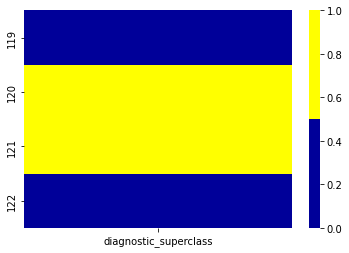

In [ ]:
sns.heatmap(y_train_rI_cat[119:123].isin(['']), cmap = sns.color_palette(colours))

In [ ]:
# процентное отношение пропущенных данных
for i in y_train_rI_cat[0:1000]:
    empty = np.mean(y_train_rI_cat[i].isin(['']))
    print('{} - {}%'.format(i, round(empty*100)))

del y_train_rI_cat

diagnostic_superclass - 2%


### Визуализация данных

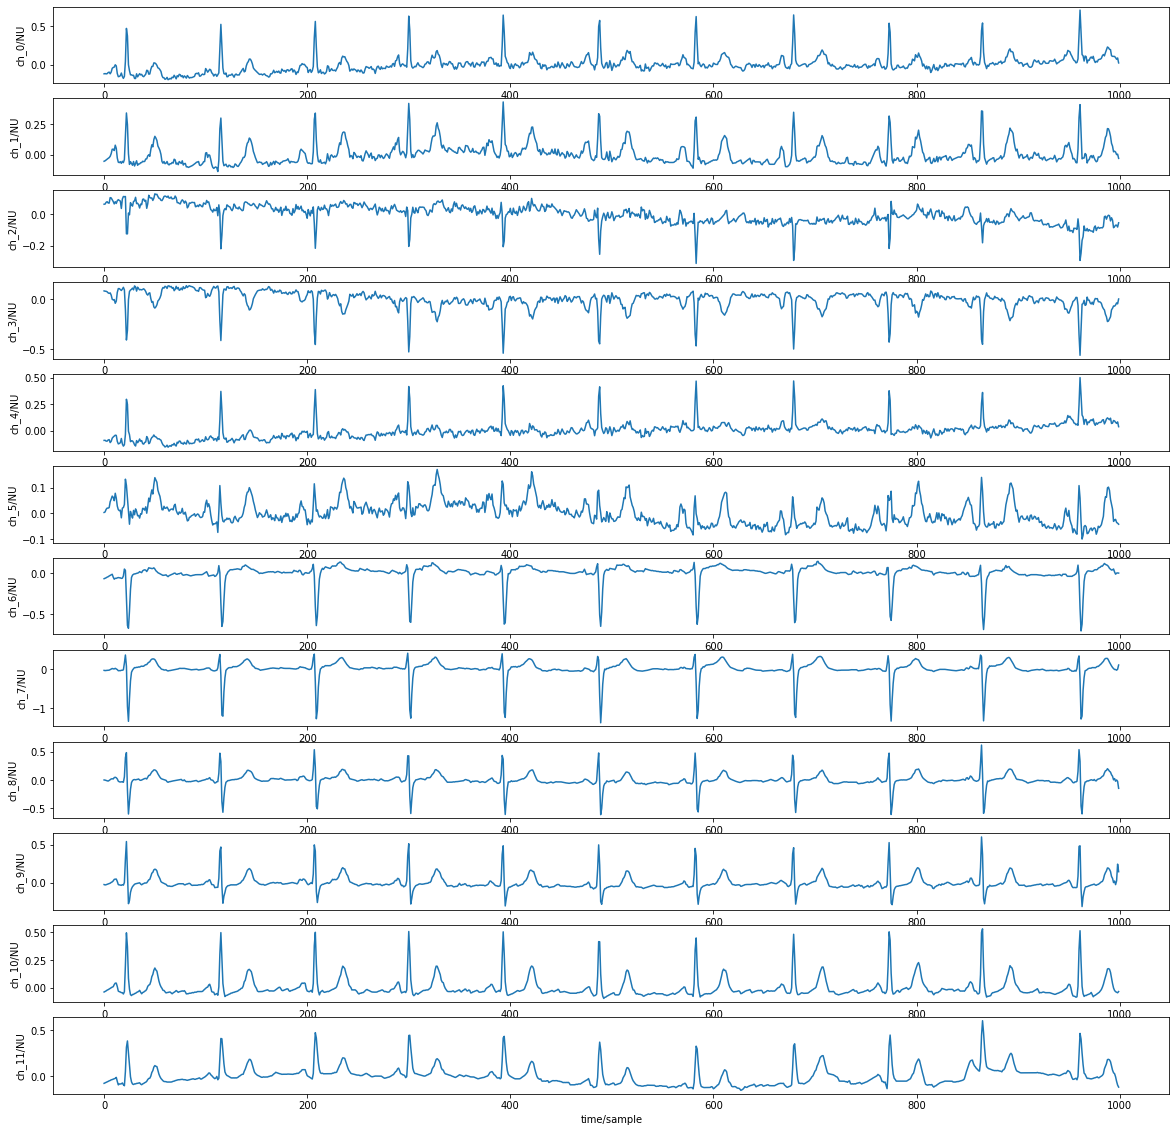

In [3]:
wfdb.plot_items(signal = X_train[0], figsize = (20, 20))

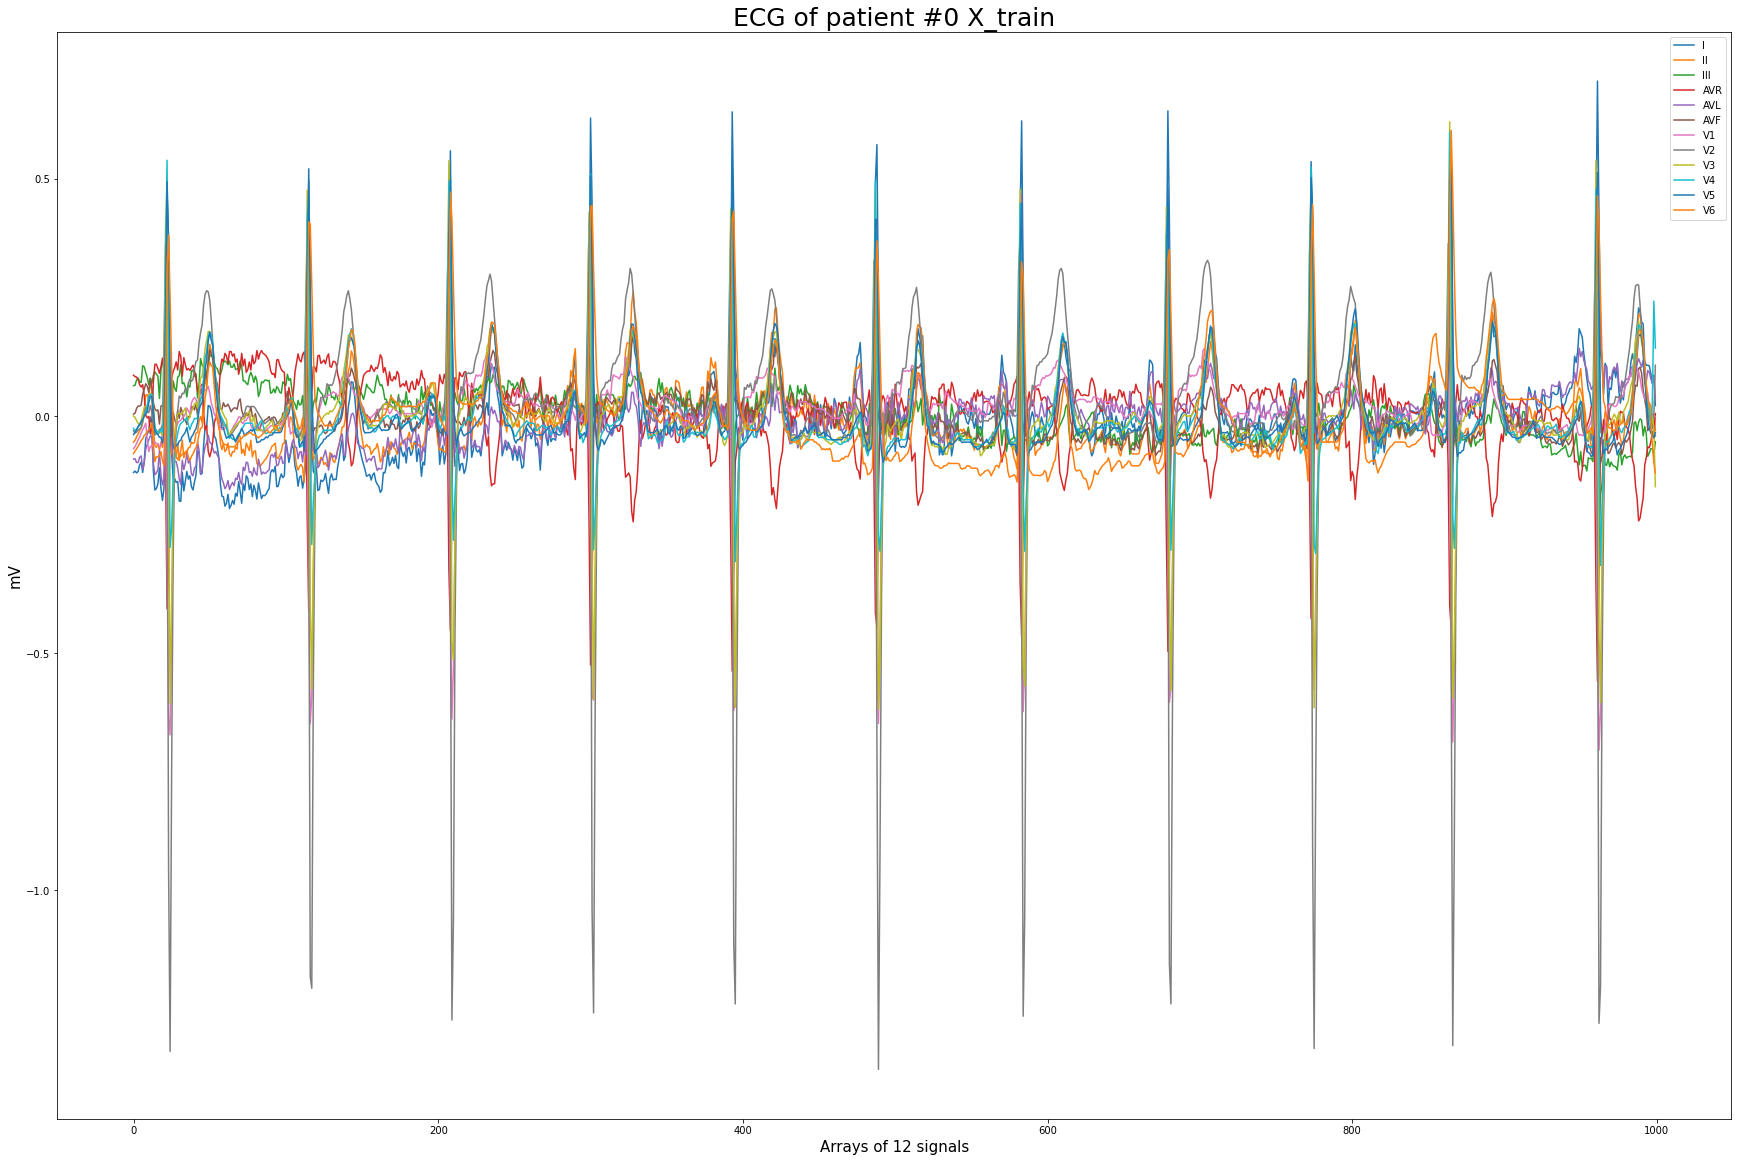

In [4]:
fig, ax = plt.subplots() # figure, axes
fig.set_figwidth(30)
fig.set_figheight(20)

labels = ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6','V345', '234']

ax.plot(X_train[0])
ax.set_xlabel('Arrays of 12 signals', fontsize = 15.)
ax.set_ylabel('mV', fontsize = 15)
ax.set_title('ECG of patient #0 X_train', fontsize = 25.)
ax.legend(labels) # label in ax.plot
pass

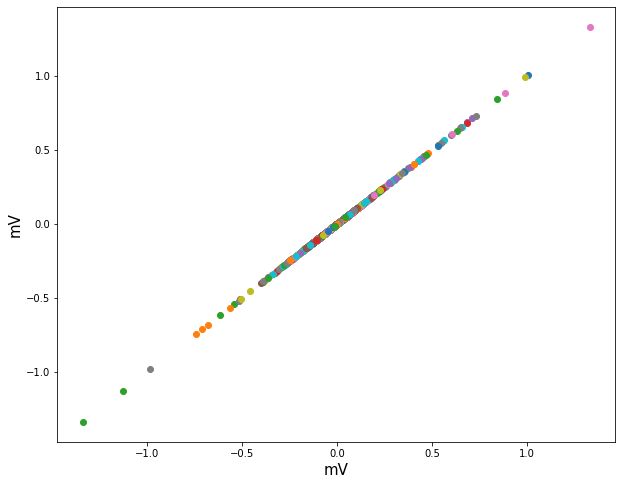

In [5]:
n_sig_min = 1
n_sig_max = 2
n_arr_min = 0
n_arr_max = 1000
steps = 1000
fig, ax = plt.subplots() # figure, axes
fig.set_figwidth(10)
fig.set_figheight(8)
labels = np.array([i for i in np.arange(0, steps)])
for i in np.arange(n_arr_min, n_arr_max):
  for j in np.arange(n_sig_min, n_sig_max):
    ax.scatter(X_train[i][j][0], X_train[i][j][0])

ax.set_xlabel('mV', fontsize = 15.)
ax.set_ylabel('mV', fontsize = 15)
pass

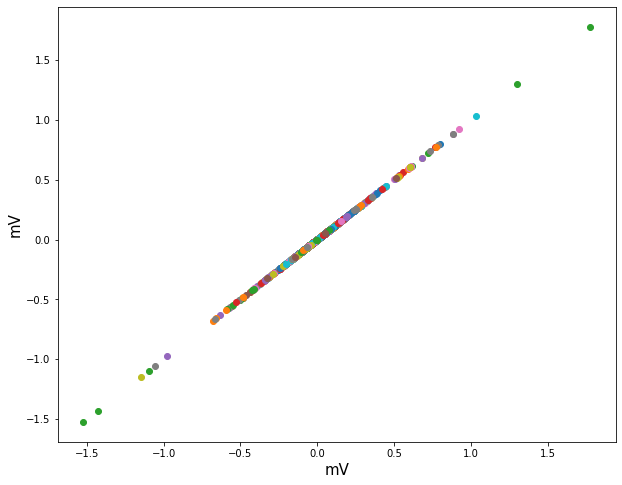

In [6]:
fig, ax = plt.subplots() # figure, axes
fig.set_figwidth(10)
fig.set_figheight(8)
labels = np.array([i for i in np.arange(0, steps)])
for i in np.arange(n_arr_min, n_arr_max):
  for j in np.arange(n_sig_min, n_sig_max):
    ax.scatter(X_train[i][j][1], X_train[i][j][1])

ax.set_xlabel('mV', fontsize = 15.)
ax.set_ylabel('mV', fontsize = 15)
pass

# Предобработка данных

### Копирование данных

In [ ]:
# Копируем исходный тренировочный и тестовый набор, чтобы не испортить данные.
y_trainCopy = y_train.copy()
X_trainCopy = X_train.copy()
y_testCopy = y_test.copy()
X_testCopy = X_test.copy()

### Обработка пустых значений

##### Тренировочные данные

###### Обработка

In [ ]:
# Выявление с помощью функции emptyLable() всех пустых меток.
sum_empty, ecg_idEmpty, ecg_idEmptyIndex = emptyLabel(y_trainCopy)

In [ ]:
# Проверка пустых значений.
print("Проверка 1: ", y_trainCopy.get(ecg_idEmpty[:5]))
print("Проверка 2: ", y_trainCopy.values[ecg_idEmptyIndex[:5]])

Проверка 1:  ecg_id
17    []
18    []
20    []
23    []
34    []
Name: diagnostic_superclass, dtype: object
Проверка 2:  [list([]) list([]) list([]) list([]) list([])]


In [ ]:
# Удалим соответствующие строки по ecg_id в X_trainCopy и в y_trainCopy.
y_trainCopy.drop(labels = ecg_idEmpty, axis = 0, inplace = True)
#y_trainCopy.reset_index(drop = True, inplace = True)
X_trainCopy = np.delete(X_trainCopy, ecg_idEmptyIndex, axis = 0)

In [ ]:
# Проверим размерности наших данных.
print(y_trainCopy.shape, X_trainCopy.shape)

(19267,) (19267, 1000, 12)


In [ ]:
# Создать Ndarray Numpy копию Series Pandas c исключенными пустыми значениями.
y_trainNpCopy = y_trainCopy.to_numpy()
print(y_trainNpCopy.size)

19267


In [ ]:
# Разделяем метки с несколькими значениями: например, y[i] = [['NORM'], ['CD'], ['HYP']]
X_trainCopy, y_trainNpCopy = splitData(X_trainCopy, y_trainNpCopy)

# Конвертируем list в str.
y_trainCopy = []
for i in range(y_trainNpCopy.size):
  y_trainCopy.append(''.join(y_trainNpCopy[i].tolist()))
y_trainCopy = np.array(y_trainCopy)

# Удаление старого numpy объекта
del y_trainNpCopy

# Сохранить файлы X_trainCopy и y_trainCopy, y_trainNpCopy.
np.save('X_trainCopy', X_trainCopy)
np.save('y_trainCopy', y_trainCopy)

# Размерности и содержимое данных.
print(y_trainCopy.shape, X_trainCopy.shape, '\n')

# Все уникальные классы.
np.unique(y_trainCopy, return_counts = True)

(25025,) (25025, 1000, 12) 



(array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype='<U4'),
 array([4409, 2392, 4933, 8564, 4727], dtype=int64))

###### Скачать

In [5]:
# Загрузка данных (не требуется выполнять код выше). y_trainNpCopy не загружается.
X_trainCopy = np.load('X_trainCopy.npy')
y_trainCopy = np.load('y_trainCopy.npy')

##### Тестовые данные

###### Обработка

In [ ]:
# Очистка данных с пустыми метками.
# Выявление пустых значений.
sum_empty, ecg_idEmpty, ecg_idEmptyIndex = emptyLabel(y_testCopy)
# Удалим соответствующие строки по ecg_id в X_trainCopy и y_trainCopy.
y_testCopy.drop(labels = ecg_idEmpty, axis = 0, inplace = True)
X_testCopy = np.delete(X_testCopy, ecg_idEmptyIndex, axis = 0)

# Создать ndarray Numpy копию Series Pandas.
y_testNpCopy = y_testCopy.to_numpy()
print(y_testNpCopy.size)

# Разделяем метки с несколькими значениями.
X_testCopy, y_testNpCopy = splitData(X_testCopy, y_testNpCopy)

# Конвертируем list в str.
y_testCopy = []
for i in range(y_testNpCopy.size):
  y_testCopy.append(''.join(y_testNpCopy[i].tolist()))
y_testCopy = np.array(y_testCopy)

# Сохранить файлы X_testCopy и y_testCopy.
np.save('X_testCopy', X_testCopy)
np.save('y_testCopy', y_testCopy)

# Проверим размерности и содержимое данных.
print(y_testCopy.shape, X_testCopy.shape)

2163
(2801,) (2801, 1000, 12)


###### Скачать

In [6]:
# Загрузка тестовых файлов.
X_testCopy = np.load('X_testCopy.npy')
y_testCopy = np.load('y_testCopy.npy')

### Нормализация данных

##### Тренировочные данные

In [7]:
# Нормирование от -1 до 1: [-1, 1] значений всех образцов.

# Минимальное и максимальное значение в 3D массивe X_trainCopy. (см. функции np.amax и np.amin)
print(np.amax(X_trainCopy))
print(np.amin(X_trainCopy))
# По осям.
# print(np.amax(X_trainCopy, axis = 0))
# print(np.amin(X_trainCopy, axis = 0))
# print(np.amax(X_trainCopy, axis = 1))
# print(np.amin(X_trainCopy, axis = 1))
# print(np.amax(X_trainCopy, axis = 2))
# print(np.amin(X_trainCopy, axis = 2))

# Нахождение максимального по абсолютному значению.
print(np.max(np.abs(X_trainCopy)))
# print(np.max(np.abs(X_trainCopy), axis = 0))
# print(np.max(np.abs(X_trainCopy), axis = 1))
# print(np.max(np.abs(X_trainCopy), axis = 2))

X_trainCopyNorm = X_trainCopy/(np.amax(np.abs(X_trainCopy)))
print(np.max(X_trainCopyNorm))
print(np.min(X_trainCopyNorm))
# Аналогично.
# print(np.amax(X_trainCopyNorm))
# print(np.amin(X_trainCopyNorm))

17.212
-20.032
20.032
0.8592252396166135
-1.0


##### Тестовые данные

In [8]:
# Нормирование от -1 до 1: [-1, 1]

# Нахождение максимального по абсолютному значению.
print(np.max(np.abs(X_testCopy)))

# Нормировка.
X_testCopyNorm = X_testCopy/(np.amax(np.abs(X_trainCopy)))
print(np.max(X_testCopyNorm))
print(np.min(X_testCopyNorm))

12.966
0.6472643769968051
-0.569888178913738


### Обработка категориальных атрибутов

##### Тренировочные данные

###### 1 вариант

In [9]:
# 1 вар.
# Разреженные метки (для каждого образца имеется только индекс целевого класса от 0 до 4). (Применяется функция потери "sparse_categorical_crossentropy")
ordinal_encoder = OrdinalEncoder()
y_trainCopyEncoded = ordinal_encoder.fit_transform(pd.DataFrame(y_trainCopy))
print(y_trainCopyEncoded[:10])
print(ordinal_encoder.categories_)

[[3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [3.]
 [2.]
 [3.]
 [3.]]
[array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)]


###### 2 вариант

In [ ]:
# 2 вар.
# Целевая вероятность на класс. (Применяется функция потери "categorical_crossentropy"). Также можно было воспользоваться функцией keras.utils.to_categorical(), чтобы преобразовать разреженные метки
#в метки, представляемые векторами. Чтобы сделать наоборот: np.argmax() с axis = 1.
cat_encoder = OneHotEncoder(sparse=False)
y_trainCopyHot = cat_encoder.fit_transform(pd.DataFrame(y_trainCopy))
print(y_trainCopyHot[:10])
print(cat_encoder.categories_)

[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]
[array(['CD', 'HYP', 'MI', 'NORM', 'STTC'], dtype=object)]


##### Тестовые данные

###### 1 вариант

In [10]:
# Разреженные метки (для каждого образца имеется только индекс целевого класса от 0 до 4). (Применяется функция потери "sparse_categorical_crossentropy")
ordinal_encoder = OrdinalEncoder()
y_testCopyEncoded = ordinal_encoder.fit_transform(pd.DataFrame(y_testCopy))
y_testCopyEncoded[:10]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.],
       [2.],
       [0.],
       [3.],
       [3.],
       [3.]])

###### 2 вариант

In [ ]:
# Целевая вероятность на класс.
cat_encoder = OneHotEncoder(sparse=False)
y_testCopyHot = cat_encoder.fit_transform(pd.DataFrame(y_testCopy))
y_testCopyHot[:10]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.]])

# Создание, обучение и тестирование разных моделей нейронных сетей, в том числе известные архитектуры
Обучение модели будет проходить с использованием тренировочных (train) и проверочных (valid) данных.  
Оценка работы модели производится с применением тестовых данных (test).

### Полносвязная нейронная сеть

##### Преобразование данных для работы с сетью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25025, 1000, 12) (25025, 1) (2801, 1000, 12) (2801, 1)


##### Создание модели

In [ ]:
# Создание обычной полносвязной модели.

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = [1000,12])) # входной слой (преобразование входного изображения X в одномерный массив: X.reshape(-1, 1))
model.add(keras.layers.Dense(10000, activation="relu")) # скрытый слой
model.add(keras.layers.Dense(3000, activation="relu"))
model.add(keras.layers.Dense(800, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(5, activation="softmax")) # выходной слой

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 12000)             0         
                                                                 
 dense (Dense)               (None, 10000)             120010000 
                                                                 
 dense_1 (Dense)             (None, 3000)              30003000  
                                                                 
 dense_2 (Dense)             (None, 800)               2400800   
                                                                 
 dense_3 (Dense)             (None, 100)               80100     
                                                                 
 dense_4 (Dense)             (None, 5)                 505       
                                                                 
Total params: 152,494,405
Trainable params: 152,494,405


##### Обучение модели

In [ ]:
# Компиляция модели.
model.compile(loss = "sparse_categorical_crossentropy",
              optimizer = "sgd",
              metrics = ["accuracy"])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_Neural1/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks=[model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save('Neural1.h5')

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 19s 26ms/step - loss: 1.4712 - accuracy: 0.4194 - val_loss: 1.9151 - val_accuracy: 0.0314
Epoch 2/30
626/626 [==============================] - 15s 24ms/step - loss: 1.4406 - accuracy: 0.4199 - val_loss: 1.8737 - val_accuracy: 0.0320
Epoch 3/30
626/626 [==============================] - 16s 25ms/step - loss: 1.4249 - accuracy: 0.4242 - val_loss: 1.8646 - val_accuracy: 0.0426
Epoch 4/30
626/626 [==============================] - 16s 25ms/step - loss: 1.4102 - accuracy: 0.4353 - val_loss: 1.8231 - val_accuracy: 0.0611
Epoch 5/30
626/626 [==============================] - 15s 25ms/step - loss: 1.3988 - accuracy: 0.4404 - val_loss: 1.8200 - val_accuracy: 0.0723
Epoch 6/30
626/626 [==============================] - 16s 26ms/step - loss: 1.3905 - accuracy: 0.4429 - val_loss: 1.7832 - val_accuracy: 0.0883
Epoch 7/30
626/626 [==============================] - 16s 25ms/step - loss: 1.3829 - accuracy: 0.4448 - val_loss: 1.7764 - val_accuracy:

##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 1s 8ms/step - loss: 1.5121 - accuracy: 0.3252


[1.5121192932128906, 0.32524099946022034]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

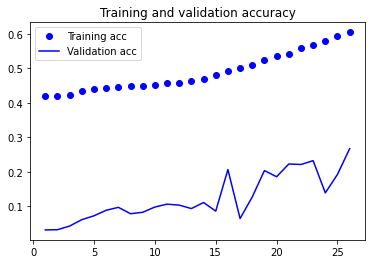

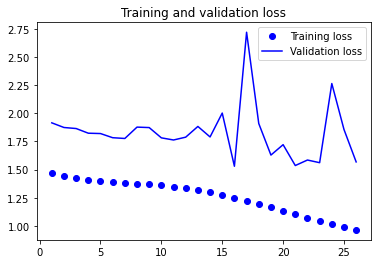

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

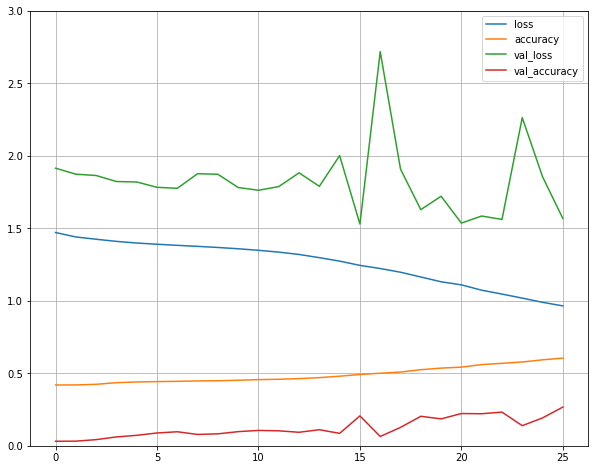

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 3)
plt.show()

### Одномерная сверточная нейроная сеть

##### Преобразование данных для работы с сетью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(25025, 1000, 12) (25025, 1) (2801, 1000, 12) (2801, 1)


##### Создание модели

In [ ]:
# _3
model = keras.Sequential([
  keras.layers.Conv1D(filters = 8, kernel_size = 16, padding = 'same', strides = 2, activation = 'relu', input_shape = (1000, 12)),
  keras.layers.MaxPooling1D(pool_size=8, strides = 4, padding = 'same'),
  keras.layers.Conv1D(filters = 12, kernel_size = 12, activation='relu', padding = 'same', strides = 2),
  keras.layers.MaxPooling1D(pool_size=4, strides = 2, padding = 'same'),
  keras.layers.Conv1D(filters = 32, kernel_size = 9, padding = 'same', strides = 1, activation = 'relu'),
  keras.layers.MaxPooling1D(pool_size=5, strides = 2,padding = 'same'),
  keras.layers.Conv1D(filters = 64, kernel_size = 7, padding = 'same', strides = 1, activation = 'relu'),
  keras.layers.MaxPooling1D(pool_size=4, strides = 2, padding = 'same'),
  keras.layers.Conv1D(filters = 64, kernel_size = 5, padding = 'same', strides = 1, activation = 'relu'),
  keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same'),
  keras.layers.Conv1D(filters = 64, kernel_size = 3, padding = 'same', strides = 1, activation = 'relu'),
  keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same'),
  keras.layers.Conv1D(filters = 72, kernel_size = 3, padding = 'same', strides = 1, activation = 'relu'),
  keras.layers.MaxPooling1D(pool_size=2, strides = 2, padding = 'same'),
  keras.layers.Flatten(),
  keras.layers.Dense(216, activation='relu'),
  keras.layers.Dropout(0.1),
  keras.layers.Dense(5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 500, 8)            1544      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 125, 8)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 63, 12)            1164      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 32, 12)           0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 32, 32)            3488      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 16, 32)           0

##### Обучение модели

In [ ]:
# Компиляция модели
model.compile(optimizer='nadam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_1D/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_split=0.2, callbacks = [model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save('1D.h5')

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 19s 11ms/step - loss: 1.1929 - accuracy: 0.5162 - val_loss: 1.5038 - val_accuracy: 0.2571
Epoch 2/30
626/626 [==============================] - 6s 10ms/step - loss: 1.0655 - accuracy: 0.5673 - val_loss: 1.4665 - val_accuracy: 0.2921
Epoch 3/30
626/626 [==============================] - 6s 9ms/step - loss: 1.0096 - accuracy: 0.6101 - val_loss: 1.6917 - val_accuracy: 0.3253
Epoch 4/30
626/626 [==============================] - 6s 10ms/step - loss: 0.9707 - accuracy: 0.6326 - val_loss: 1.4382 - val_accuracy: 0.3648
Epoch 5/30
626/626 [==============================] - 6s 10ms/step - loss: 0.9263 - accuracy: 0.6476 - val_loss: 1.3989 - val_accuracy: 0.3724
Epoch 6/30
626/626 [==============================] - 6s 10ms/step - loss: 0.8961 - accuracy: 0.6550 - val_loss: 1.3796 - val_accuracy: 0.3868
Epoch 7/30
626/626 [==============================] - 6s 9ms/step - loss: 0.8815 - accuracy: 0.6625 - val_loss: 1.4598 - val_accuracy: 0.3782


##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 0s 5ms/step - loss: 0.9877 - accuracy: 0.6034


[0.987737774848938, 0.6033559441566467]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

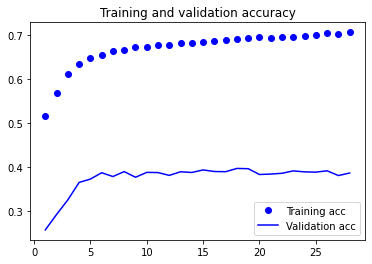

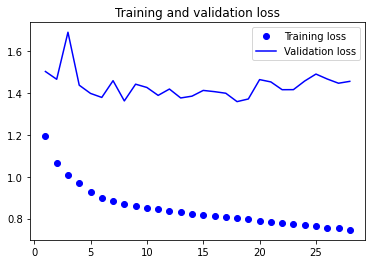

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

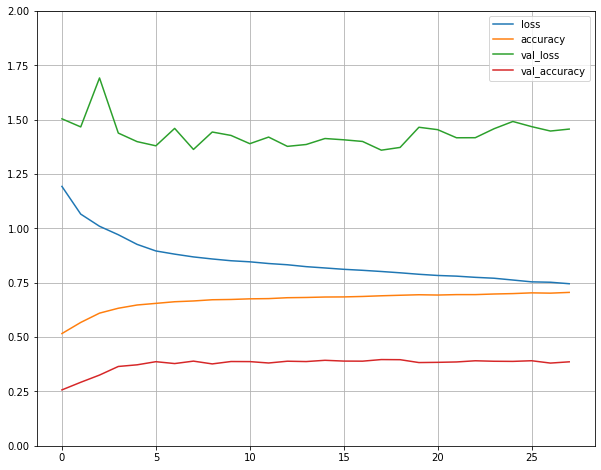

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()

### Двумерная сверточная нейронная сеть

##### Преобразование данных для работы с моделью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

# До преобразования.
X_train.shape, X_test.shape
# Преобразование формы тензора.
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]
# После преобразования.
X_train.shape, X_test.shape

##### Создание модели

In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size = 3, activation = "relu", padding = "SAME")

model = keras.models.Sequential([
  DefaultConv2D(filters = 64, kernel_size = 7, input_shape = [1000, 12, 1]),
  keras.layers.MaxPooling2D(pool_size = 2),
  DefaultConv2D(filters = 128),
  DefaultConv2D(filters = 128),
  keras.layers.MaxPooling2D(pool_size = 2),
  DefaultConv2D(filters = 256),
  DefaultConv2D(filters = 256),
  keras.layers.MaxPooling2D(pool_size = 2),
  keras.layers.Flatten(),
  keras.layers.Dense(units=128, activation = "relu"),
    keras.layers.Dropout(0.5),
  keras.layers.Dense(units=64, activation = "relu"),
  keras.layers.Dropout(0.5),
  keras.layers.Dense(units = 5, activation = "softmax"),
])

print(model.summary())
# # Список слоев модели.
# print(model.layers)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 12, 64)      3200      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 500, 6, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 500, 6, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 500, 6, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 250, 3, 128)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 250, 3, 256)       2

##### Обучение модели

In [ ]:
# Компиляция модели.
model.compile(loss = 'sparse_categorical_crossentropy',
              optimizer = 'nadam',
              metrics = ['accuracy'])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_2D/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 10, validation_split = 0.2, callbacks=[model_checkpoint_cb, early_stopping_cb]) 

# Сохранение модели.
model.save('2D.h5')

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)


##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 3s 30ms/step - loss: 1.0279 - accuracy: 0.6012


[1.0278685092926025, 0.6012138724327087]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

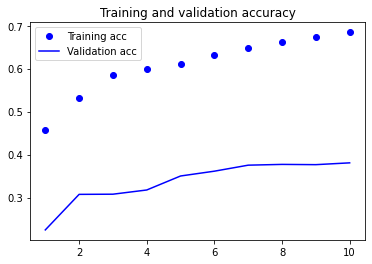

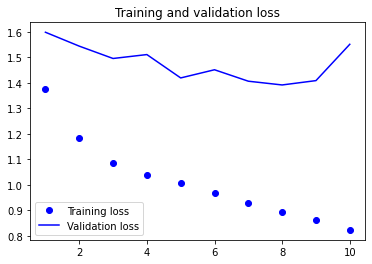

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

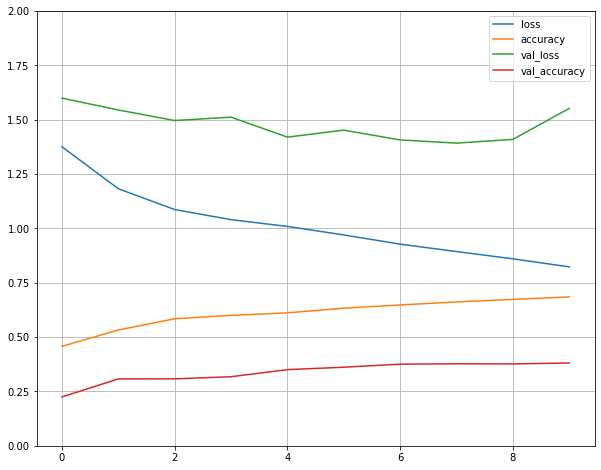

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()

### ResNet50

##### Преобразование данных для работы с моделью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

# До преобразования.
X_train.shape, X_test.shape
# Преобразование формы тензора.
X_train = np.reshape(X_train, (25025, -1, 32, 3))
X_test = np.reshape(X_test, (2801, -1, 32, 3))
# После преобразования.
X_train.shape, X_test.shape

((25025, 125, 32, 3), (2801, 125, 32, 3))

##### Загрузка модели

In [ ]:
conv_base = keras.applications.ResNet50(weights='imagenet',
                                           include_top = False,
                                           input_shape = (125, 32, 3)
                                          )
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

94781440/94765736 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 1, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 25,686,405
Trainable params: 25,633,285
Non-trainable params: 53,120
_________________________________________________________________


##### Обучение модели

In [ ]:
# Замораживание сверточной основы.
conv_base.trainable = False

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Обучение.
history = model.fit(X_train, y_train, epochs = 5, validation_split = 0.2)

Epoch 1/5
626/626 [==============================] - 30s 28ms/step - loss: 1.5195 - accuracy: 0.3940 - val_loss: 1.9083 - val_accuracy: 0.0314
Epoch 2/5
626/626 [==============================] - 15s 25ms/step - loss: 1.4612 - accuracy: 0.4199 - val_loss: 1.9371 - val_accuracy: 0.0314
Epoch 3/5
626/626 [==============================] - 16s 26ms/step - loss: 1.4591 - accuracy: 0.4199 - val_loss: 1.8357 - val_accuracy: 0.0314
Epoch 4/5
626/626 [==============================] - 16s 25ms/step - loss: 1.4584 - accuracy: 0.4199 - val_loss: 1.8656 - val_accuracy: 0.0314
Epoch 5/5
626/626 [==============================] - 15s 25ms/step - loss: 1.4581 - accuracy: 0.4199 - val_loss: 1.9802 - val_accuracy: 0.0314


In [ ]:
# Разморозка сверточной основы.
conv_base.trainable = True

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_ResNet50/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks=[model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save("ResNet50.h5")

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 75s 89ms/step - loss: 1.1972 - accuracy: 0.5618 - val_loss: 1.8524 - val_accuracy: 0.2492
Epoch 2/30
626/626 [==============================] - 54s 86ms/step - loss: 1.0176 - accuracy: 0.6128 - val_loss: 1.9863 - val_accuracy: 0.2797
Epoch 3/30
626/626 [==============================] - 54s 87ms/step - loss: 0.9905 - accuracy: 0.6180 - val_loss: 1.5982 - val_accuracy: 0.1790
Epoch 4/30
626/626 [==============================] - 57s 92ms/step - loss: 0.9939 - accuracy: 0.6235 - val_loss: 1.4700 - val_accuracy: 0.3606
Epoch 5/30
626/626 [==============================] - 53s 85ms/step - loss: 0.9398 - accuracy: 0.6319 - val_loss: 1.6144 - val_accuracy: 0.3457
Epoch 6/30
626/626 [==============================] - 53s 85ms/step - loss: 0.9167 - accuracy: 0.6413 - val_loss: 1.6112 - val_accuracy: 0.3415
Epoch 7/30
626/626 [==============================] - 54s 86ms/step - loss: 0.9106 - accuracy: 0.6484 - val_loss: 1.5525 - val_accuracy:

##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 2s 24ms/step - loss: 1.1361 - accuracy: 0.5484


[1.1360713243484497, 0.5483756065368652]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

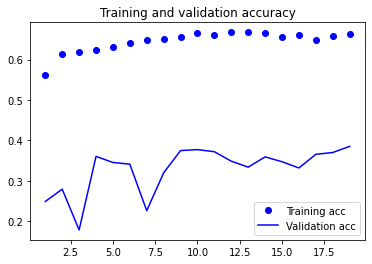

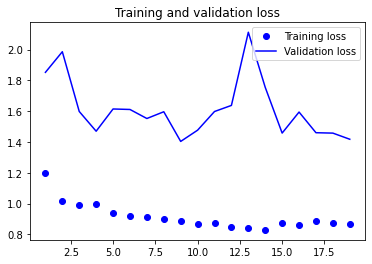

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

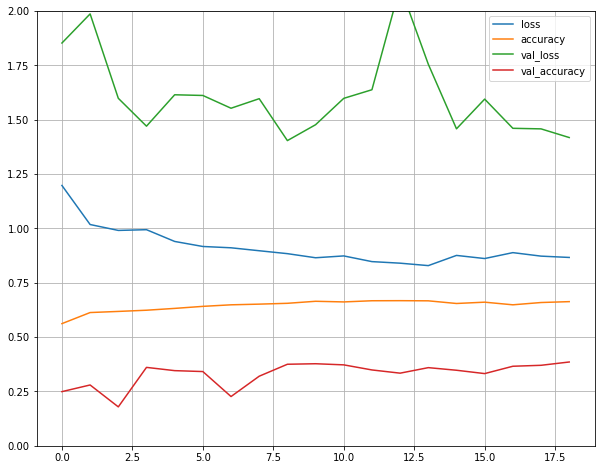

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()

### ResNet50V2

##### Преобразование данных для работы с моделью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

# До преобразования.
X_train.shape, X_test.shape
# Преобразование формы тензора.
X_train = np.reshape(X_train, (25025, -1, 32, 3))
X_test = np.reshape(X_test, (2801, -1, 32, 3))
# После преобразования.
X_train.shape, X_test.shape

##### Загрузка модели

In [ ]:
conv_base = keras.applications.ResNet50V2(weights='imagenet',
                                           include_top = False,
                                           input_shape = (125, 32, 3)
                                          )
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

94683136/94668760 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 4, 1, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 25,663,493
Trainable params: 25,618,053
Non-trainable params: 45,440
_________________________________________________________________


##### Обучение модели

In [ ]:
# Замораживание сверточной основы.
conv_base.trainable = False

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение.
history = model.fit(X_train, y_train, epochs = 5, validation_split = 0.2)

Epoch 1/5
626/626 [==============================] - 29s 26ms/step - loss: 1.2964 - accuracy: 0.4819 - val_loss: 1.7045 - val_accuracy: 0.2511
Epoch 2/5
626/626 [==============================] - 14s 23ms/step - loss: 1.2252 - accuracy: 0.5113 - val_loss: 1.7106 - val_accuracy: 0.2238
Epoch 3/5
626/626 [==============================] - 14s 22ms/step - loss: 1.1911 - accuracy: 0.5249 - val_loss: 1.5909 - val_accuracy: 0.2957
Epoch 4/5
626/626 [==============================] - 15s 24ms/step - loss: 1.1656 - accuracy: 0.5371 - val_loss: 1.7434 - val_accuracy: 0.2396
Epoch 5/5
626/626 [==============================] - 14s 23ms/step - loss: 1.1400 - accuracy: 0.5448 - val_loss: 1.6276 - val_accuracy: 0.2903


In [ ]:
# Разморозка сверточной основы.
conv_base.trainable = True

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_ResNet50V2/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks = [model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save("ResNet50V2.h5")

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 71s 84ms/step - loss: 1.3228 - accuracy: 0.5051 - val_loss: 1.5763 - val_accuracy: 0.2603
Epoch 2/30
626/626 [==============================] - 52s 83ms/step - loss: 1.1102 - accuracy: 0.5709 - val_loss: 1.4023 - val_accuracy: 0.3355
Epoch 3/30
626/626 [==============================] - 49s 79ms/step - loss: 1.0338 - accuracy: 0.6052 - val_loss: 1.7224 - val_accuracy: 0.2937
Epoch 4/30
626/626 [==============================] - 49s 78ms/step - loss: 1.1499 - accuracy: 0.5547 - val_loss: 1.4674 - val_accuracy: 0.2945
Epoch 5/30
626/626 [==============================] - 49s 79ms/step - loss: 1.0932 - accuracy: 0.5741 - val_loss: 1.5473 - val_accuracy: 0.2781
Epoch 6/30
626/626 [==============================] - 49s 79ms/step - loss: 1.0386 - accuracy: 0.5886 - val_loss: 1.5171 - val_accuracy: 0.3273
Epoch 7/30
626/626 [==============================] - 51s 81ms/step - loss: 0.9769 - accuracy: 0.6161 - val_loss: 1.3511 - val_accuracy:

##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 2s 24ms/step - loss: 1.0848 - accuracy: 0.5502


[1.0847526788711548, 0.5501606464385986]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

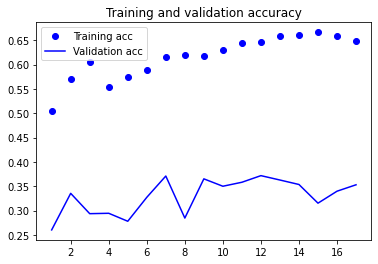

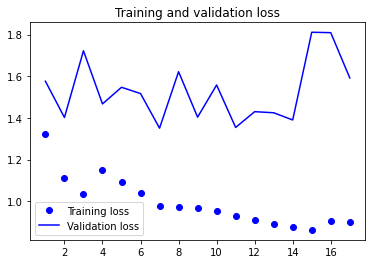

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

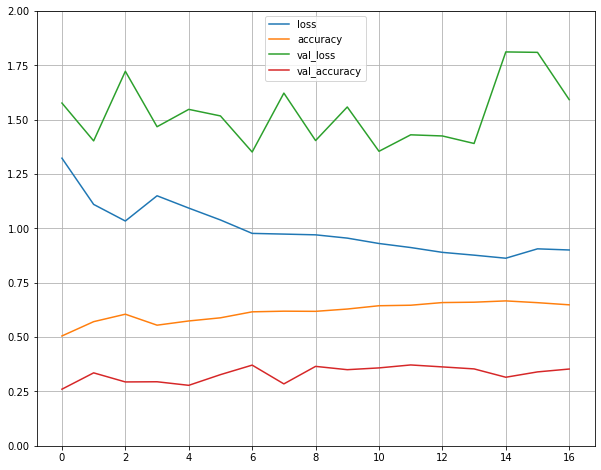

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()

### ResNet101

##### Преобразование данных для работы с моделью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

# До преобразования.
X_train.shape, X_test.shape
# Преобразование формы тензора.
X_train = np.reshape(X_train, (25025, -1, 32, 3))
X_test = np.reshape(X_test, (2801, -1, 32, 3))
# После преобразования.
X_train.shape, X_test.shape

((25025, 125, 32, 3), (2801, 125, 32, 3))

##### Загрузка модели

In [ ]:
conv_base = keras.applications.ResNet101(weights='imagenet',
                                           include_top = False,
                                           input_shape = (125, 32, 3)
                                          )
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

171458560/171446536 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet101 (Functional)      (None, 4, 1, 2048)        42658176  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 256)               2097408   
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 44,756,869
Trainable params: 44,651,525
Non-trainable params: 105,344
_________________________________________________________________


##### Обучение модели

In [ ]:
# Замораживание сверточной основы.
conv_base.trainable = False

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение.
history = model.fit(X_train, y_train, epochs = 5, validation_split = 0.2)

Epoch 1/5
626/626 [==============================] - 48s 53ms/step - loss: 1.4747 - accuracy: 0.4145 - val_loss: 1.8435 - val_accuracy: 0.0314
Epoch 2/5
626/626 [==============================] - 27s 43ms/step - loss: 1.4552 - accuracy: 0.4199 - val_loss: 2.1549 - val_accuracy: 0.0314
Epoch 3/5
626/626 [==============================] - 26s 41ms/step - loss: 1.4517 - accuracy: 0.4199 - val_loss: 1.9002 - val_accuracy: 0.0314
Epoch 4/5
626/626 [==============================] - 26s 41ms/step - loss: 1.4463 - accuracy: 0.4199 - val_loss: 1.9268 - val_accuracy: 0.0314
Epoch 5/5
626/626 [==============================] - 26s 42ms/step - loss: 1.4400 - accuracy: 0.4205 - val_loss: 1.7263 - val_accuracy: 0.0338


In [ ]:
# Разморозка сверточной основы.
conv_base.trainable = True

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_ResNet101/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks = [model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save("ResNet101.h5")

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 134s 156ms/step - loss: 1.2938 - accuracy: 0.5159 - val_loss: 1.5702 - val_accuracy: 0.2615
Epoch 2/30
626/626 [==============================] - 91s 145ms/step - loss: 1.1369 - accuracy: 0.5499 - val_loss: 2.1732 - val_accuracy: 0.2551
Epoch 3/30
626/626 [==============================] - 95s 152ms/step - loss: 1.0303 - accuracy: 0.6003 - val_loss: 1.5549 - val_accuracy: 0.3524
Epoch 4/30
626/626 [==============================] - 94s 150ms/step - loss: 1.1067 - accuracy: 0.5684 - val_loss: 1.4837 - val_accuracy: 0.2919
Epoch 5/30
626/626 [==============================] - 91s 145ms/step - loss: 1.1025 - accuracy: 0.5668 - val_loss: 1.5630 - val_accuracy: 0.1337
Epoch 6/30
626/626 [==============================] - 91s 145ms/step - loss: 1.0549 - accuracy: 0.5840 - val_loss: 1.5579 - val_accuracy: 0.3189
Epoch 7/30
626/626 [==============================] - 91s 146ms/step - loss: 0.9959 - accuracy: 0.6090 - val_loss: 1.8601 - val_a

##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 3s 38ms/step - loss: 1.4233 - accuracy: 0.4223


[1.4233031272888184, 0.42234915494918823]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

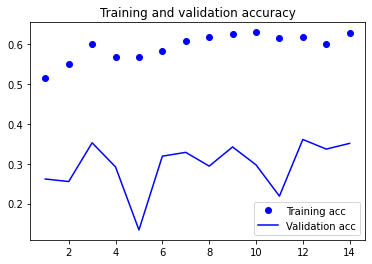

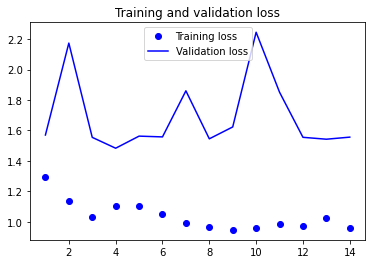

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

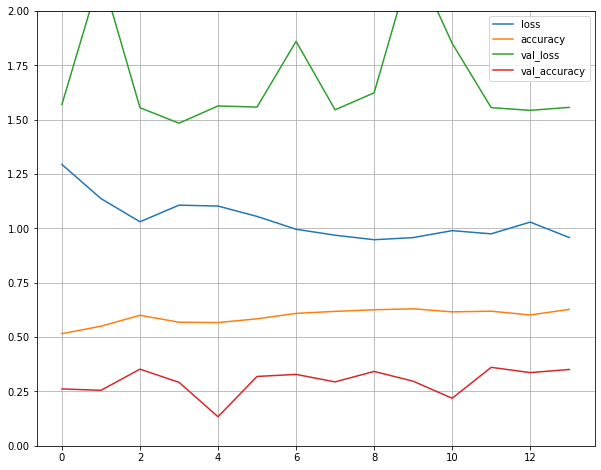

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()

### VGG16

##### Преобразование данных для работы с моделью

In [11]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

# До преобразования.
X_train.shape, X_test.shape
# Преобразование формы тензора.
X_train = np.reshape(X_train, (25025, -1, 32, 3))
X_test = np.reshape(X_test, (2801, -1, 32, 3))
# После преобразования.
X_train.shape, X_test.shape

((25025, 125, 32, 3), (2801, 125, 32, 3))

##### Загрузка модели

In [12]:
conv_base = keras.applications.vgg16.VGG16(weights='imagenet',
                                           include_top = False,
                                           input_shape = (125, 32, 3)
                                          )
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 3, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 15,109,445
Trainable params: 15,109,445
Non-trainable params: 0
_________________________________________________________________


##### Обучение модели

In [13]:
# Заморозка весов заранее обученных слоев.
for layer in conv_base.layers:
    layer.trainable = False

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение.
history = model.fit(X_train, y_train, epochs = 5, validation_split = 0.2)

Epoch 1/5
626/626 [==============================] - 27s 25ms/step - loss: 1.4333 - accuracy: 0.4279 - val_loss: 1.8356 - val_accuracy: 0.0655
Epoch 2/5
626/626 [==============================] - 14s 22ms/step - loss: 1.3976 - accuracy: 0.4407 - val_loss: 1.8282 - val_accuracy: 0.0839
Epoch 3/5
626/626 [==============================] - 14s 22ms/step - loss: 1.3808 - accuracy: 0.4469 - val_loss: 1.6240 - val_accuracy: 0.1678
Epoch 4/5
626/626 [==============================] - 14s 22ms/step - loss: 1.3655 - accuracy: 0.4497 - val_loss: 1.7195 - val_accuracy: 0.1538
Epoch 5/5
626/626 [==============================] - 14s 22ms/step - loss: 1.3499 - accuracy: 0.4560 - val_loss: 1.8182 - val_accuracy: 0.1469


In [14]:
# Разморозка весов.
for layer in conv_base.layers:
    layer.trainable = True

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_vgg16/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks = [model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save("vgg16.h5")

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 47s 67ms/step - loss: 23.1374 - accuracy: 0.4092 - val_loss: 1.9009 - val_accuracy: 0.0314
Epoch 2/30
626/626 [==============================] - 40s 63ms/step - loss: 1.4589 - accuracy: 0.4199 - val_loss: 1.9069 - val_accuracy: 0.0314
Epoch 3/30
626/626 [==============================] - 40s 64ms/step - loss: 1.4583 - accuracy: 0.4199 - val_loss: 1.9212 - val_accuracy: 0.0314
Epoch 4/30
626/626 [==============================] - 40s 65ms/step - loss: 1.4578 - accuracy: 0.4199 - val_loss: 1.8956 - val_accuracy: 0.0314
Epoch 5/30
626/626 [==============================] - 41s 65ms/step - loss: 1.4579 - accuracy: 0.4199 - val_loss: 1.8860 - val_accuracy: 0.0314
Epoch 6/30
626/626 [==============================] - 40s 65ms/step - loss: 1.4951 - accuracy: 0.4158 - val_loss: 1.8821 - val_accuracy: 0.0314
Epoch 7/30
626/626 [==============================] - 40s 64ms/step - loss: 1.4580 - accuracy: 0.4199 - val_loss: 1.9352 - val_accuracy

##### Оценка работы модели

In [15]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 2s 24ms/step - loss: 1.5352 - accuracy: 0.3442


[1.535159707069397, 0.34416279196739197]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

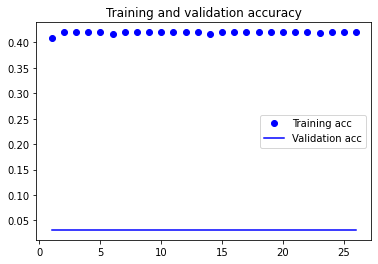

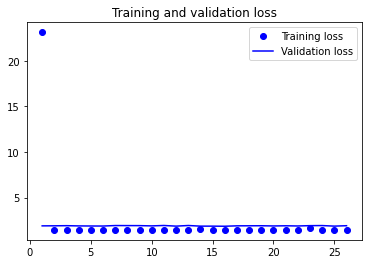

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

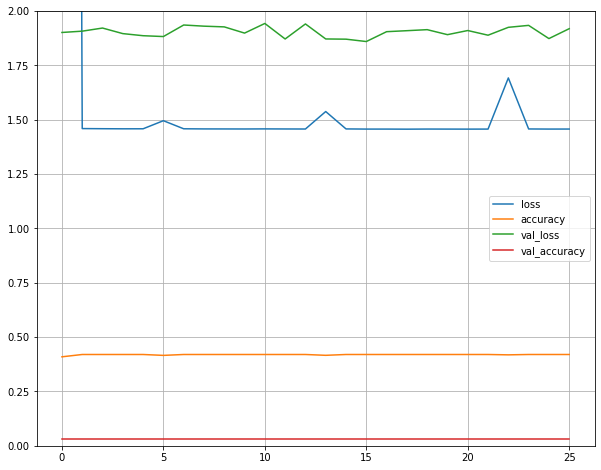

In [17]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()

### VGG19

##### Преобразование данных для работы с моделью

In [ ]:
X_train = X_trainCopyNorm
y_train = y_trainCopyEncoded
X_test = X_testCopyNorm
y_test = y_testCopyEncoded

# До преобразования.
X_train.shape, X_test.shape
# Преобразование формы тензора.
X_train = np.reshape(X_train, (25025, -1, 32, 3))
X_test = np.reshape(X_test, (2801, -1, 32, 3))
# После преобразования.
X_train.shape, X_test.shape

((25025, 125, 32, 3), (2801, 125, 32, 3))

##### Загрузка модели

In [ ]:
conv_base = keras.applications.vgg19.VGG19(weights='imagenet',
                                           include_top = False,
                                           input_shape = (125, 32, 3)
                                          )
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 3, 1, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 1536)              0         
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 20,419,141
Trainable params: 20,419,141
Non-trainable params: 0
_________________________________________________________________


##### Обучение модели

In [ ]:
# Замораживание сверточной основы.
conv_base.trainable = False

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Обучение.
history = model.fit(X_train, y_train, epochs = 5, validation_split = 0.2)

Epoch 1/5
626/626 [==============================] - 28s 28ms/step - loss: 1.4324 - accuracy: 0.4257 - val_loss: 1.7885 - val_accuracy: 0.0999
Epoch 2/5
626/626 [==============================] - 16s 26ms/step - loss: 1.3931 - accuracy: 0.4437 - val_loss: 1.8642 - val_accuracy: 0.0991
Epoch 3/5
626/626 [==============================] - 19s 30ms/step - loss: 1.3770 - accuracy: 0.4474 - val_loss: 1.7624 - val_accuracy: 0.1325
Epoch 4/5
626/626 [==============================] - 17s 27ms/step - loss: 1.3656 - accuracy: 0.4565 - val_loss: 1.7601 - val_accuracy: 0.1327
Epoch 5/5
626/626 [==============================] - 16s 26ms/step - loss: 1.3592 - accuracy: 0.4600 - val_loss: 1.9278 - val_accuracy: 0.1011


In [ ]:
# Разморозка весов.
conv_base.trainable = True

# Компиляция модели.
model.compile(optimizer = tf.keras.optimizers.Nadam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


# Реализация раннего прекращения.
checkpoint_filepath = './checkpoint_vgg19/'
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)

# Обучение.
history = model.fit(X_train, y_train, epochs = 30, validation_split = 0.2, callbacks = [model_checkpoint_cb, early_stopping_cb])

# Сохранение модели.
model.save('vgg19.h5')

# Откат к наилучшей модели.
model.load_weights(checkpoint_filepath)

Epoch 1/30
626/626 [==============================] - 58s 84ms/step - loss: 38.9503 - accuracy: 0.4085 - val_loss: 1.9018 - val_accuracy: 0.0314
Epoch 2/30
626/626 [==============================] - 49s 78ms/step - loss: 1.4581 - accuracy: 0.4199 - val_loss: 1.9127 - val_accuracy: 0.0314
Epoch 3/30
626/626 [==============================] - 50s 80ms/step - loss: 1.4576 - accuracy: 0.4199 - val_loss: 1.8677 - val_accuracy: 0.0314
Epoch 4/30
626/626 [==============================] - 50s 79ms/step - loss: 1.4570 - accuracy: 0.4199 - val_loss: 1.8642 - val_accuracy: 0.0314
Epoch 5/30
626/626 [==============================] - 49s 78ms/step - loss: 1.4576 - accuracy: 0.4199 - val_loss: 1.8991 - val_accuracy: 0.0314
Epoch 6/30
626/626 [==============================] - 49s 78ms/step - loss: 1.4570 - accuracy: 0.4199 - val_loss: 1.8772 - val_accuracy: 0.0314
Epoch 7/30
626/626 [==============================] - 49s 78ms/step - loss: 1.4580 - accuracy: 0.4199 - val_loss: 1.8882 - val_accuracy

##### Оценка работы модели

In [ ]:
score = model.evaluate(X_test, y_test)
score

88/88 [==============================] - 2s 27ms/step - loss: 1.5358 - accuracy: 0.3442


[1.5358237028121948, 0.34416279196739197]

##### Графики изменения точности и потерь модели по обучающим и проверочным данным в процессе обучения

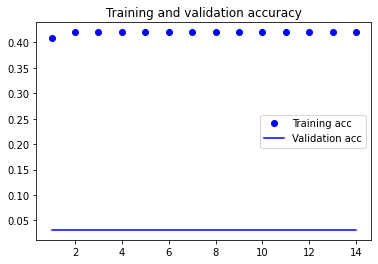

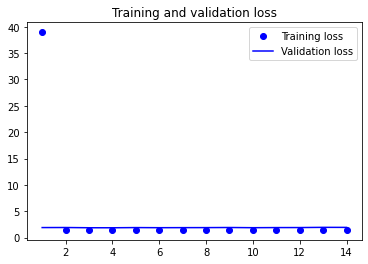

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

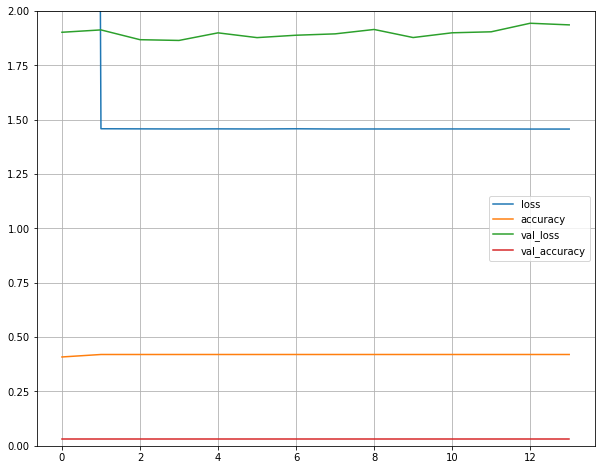

In [ ]:
pd.DataFrame(history.history).plot(figsize = (10, 8))
plt.grid()
plt.gca().set_ylim(0, 2)
plt.show()